## **CO2 emission en la generacion electrica Argentina**

#### **Índice**

1. [Introducción](#introducción)
   
   1.1. [Contexto empresarial]

   1.2. [Problema comercial]

   1.3. [Contexto analítico]

2. [Exploratory Data Analysis (EDA)](#eda)

   2.1. Panorama internacional

   2.2. Argentina
   
3. [Estimación de CO2 emissions para Argentina, sector eléctrico](#estimación-de-co2-emissions-para-argentina-sector-eléctrico)

   3.1. [Regresores simples: MCO y RandomForest](#mco)
   
   3.2. [Construyendo un SARIMAX (seasonal ARIMA con var exogenas)](#sarimax)
4. [Conclusiones](#conclusiones)


<a id="introduccion"></a>

### 1. Introduccíon

**Contexto empresarial**

 Imaginemos que me desarrollo como analista en YPF, una empresa de energía que participa activamente en la generación de electricidad en Argentina. Me han asignado un proyecto en el que debo utilizar datos históricos de emisiones de dióxido de carbono (CO2) de Our World in Data y datos de generación de electricidad por tipo de combustible y por fuente de generación en Argentina. 

La empresa está interesada en conocer la evolución de las emisiones de dióxido de carbono en la generación de electricidad en el país, ya que esto le permitirá anticipar la demanda de energía y planificar su estrategia de producción para cumplir con las regulaciones ambientales y satisfacer la creciente demanda energética de los hogares y empresas en Argentina.

**Problema comercial**

Como analista de datos, mi objetivo es utilizar las fuentes de datos disponibles para desarrollar modelos que permitan proyectar las emisiones de CO2 provenientes de la generación de electricidad en Argentina.

**Contexto analítico**

Tenemos estas dos fuentes de informacion principales y varias secundarias:

1. "owid-co2-data" contiene datos y metricas relacionados a emisiones de CO2 y de otros gases de efecto invernadero, energia, para todos los paises del mundo.

2. "electricidad_argentina" contiene informacion relevante sobre la generacion y consumo de electricidad en argentina, elaborada sobre la base de datos de CAMMESA.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import plotly
import plotly.express as px
import statsmodels
import plotly.graph_objects as go
import pycountry
from matplotlib.gridspec import GridSpec

<a id="eda"></a>
### 2. Exploratory Data Analysis (EDA)

**CO2 emissions en el mundo y Argentina**

En este primer dataset (owid-co2-data) se detallan datos sobre emisiones de gases de efecto invernadero a nivel mundial. A partir del mismo pude responder las siguientres preguntas:

Que paises son los que mas contribuyeron en perspectiva historica al acumulado de emisiones de CO2 actual.
Como se relaciona el nivel de emisiones con el Producto Bruto y con la Poblacion para este mix de paises
Como se distribuyen las emisiones segun deciles de GDP?
En el caso de Argentina me permitio responder:

Como evolucionaron las emisiones de Argentina hasta la actualidad?
Como se componen estas emisiones segun el tipo de combustible o industria en cada momento del tiempo?
Cual es el combustible que mas contribuyo a las emisiones de co2 acumuladas?

In [2]:
#Carga del primer dataset
raw=pd.read_excel(r"C:\Users\Bruno\Desktop\Curso Data Science\Dataframes\owid-co2-data.xlsx")

Antes de comenzar el análisis, es importante identificar las variables de interés y verificar si hay datos faltantes. A continuación, se presentan algunos detalles relevantes sobre el conjunto de datos:

- El conjunto de datos contiene 46,523 filas.
- La variable "Country" representa el país donde se generan las emisiones.
- La variable "GDP" corresponde al Producto Interno Bruto (PIB) medido en dólares internacionales (internacional-$). Se utiliza la referencia de precios de 2011 para ajustar por cambios de precios a lo largo del tiempo (inflación) y diferencias de precios entre los países. El PIB se calcula multiplicando el PIB per cápita por la población.
- La variable "cumulative_co2" indica las emisiones totales acumuladas de dióxido de carbono (CO₂) basadas en la producción, excluyendo los cambios de uso del suelo. Estas emisiones se miden en millones de toneladas y no consideran las emisiones incorporadas en bienes comerciados.
- La variable "population" representa la población del país correspondiente.
- La variable "co2" indica el número total anual de emisiones basadas en la producción de dióxido de carbono (CO₂), excluyendo los cambios de uso del suelo. Estas emisiones se miden en millones de toneladas.
- Las variables "coal_co2", "flaring_co2", "gas_co2", "oil_co2", "other_industry_co2" y "cement_co2" representan las emisiones acumuladas de CO₂ provenientes del carbón, la quema, el gas, el petróleo, otras industrias y el cemento, respectivamente.

Es importante tener en cuenta que la variable "Country" tiene 39,862 datos no nulos para los códigos ISO, lo cual se debe a la presencia de agrupamientos en la variable "Country" que no cuentan con códigos ISO, como la Unión Europea, entre otros.

En base a esto, dado que tenemos un panel de datos, la correccion por datos nulos debe tener en cuenta el pais (**country**) y el año (**year**). Antes de eso me quedo solo con las variables que me interesan para el analisis.

In [3]:
#Me quedo con las variables relevantes
raw = raw[['country','iso_code','gdp','year','cumulative_coal_co2','cumulative_flaring_co2','cumulative_gas_co2',
           'cumulative_luc_co2','cumulative_oil_co2','cumulative_other_co2','cumulative_cement_co2','cumulative_co2', 
           'population', 'co2', 'coal_co2','flaring_co2', 'gas_co2','land_use_change_co2', 'oil_co2','other_industry_co2', 'cement_co2']]

df_procesado = raw.copy()

df_procesado = df_procesado.dropna(subset=['iso_code'])
df_procesado = df_procesado.rename(columns={"iso_code": "country_1"})
df_procesado = df_procesado.dropna(subset=['country_1'], axis=0, inplace=False)

# ordeno los datos por país y año
df_procesado = df_procesado.sort_values(['country', 'year'])

In [4]:
#Interpolo los valores faltantes de las variables seleccionadas
vars_to_interpolate = ['cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2', 
                       'cumulative_oil_co2', 'cumulative_other_co2', 'cumulative_co2', 'population', 'co2', 'coal_co2',
                       'flaring_co2', 'gas_co2', 'oil_co2', 'other_industry_co2', 'cement_co2', 'gdp']
"""
group_cols = ['country', 'year']
df_procesado[vars_to_interpolate] = df_procesado.groupby(group_cols)[vars_to_interpolate].apply(lambda group: group.interpolate(method='nearest'))
"""

#Relleno los valores faltantes con el último valor válido para cada país a partir de 2018
df_procesado.loc[df_procesado['year'] >= 2018, vars_to_interpolate] = df_procesado.loc[df_procesado['year'] >= 2018].groupby('country')[vars_to_interpolate].fillna(method='ffill')
df_procesado = df_procesado.sort_values(['year', 'country'])

Para simplificar el conjunto de datos sin perder información, selecciono los países que representen la mayor parte de las emisiones acumuladas, junto con Argentina. Según Our World in Data, los principales emisores son los siguientes:

1. China
2. Estados Unidos
3. Países de la Unión Europea (considerados en conjunto)
4. India
5. Canadá
6. Brasil
7. Países del sur de África (considerados en conjunto)
8. Reino Unido

Además de estos países, se incluirá a Argentina. Los demás países se agruparán bajo la categoría "Resto".

In [5]:
# Códigos ISO de los países de la UE y del sur de Africa
eu_countries = ['AT', 'BE', 'BG', 'HR', 'CY', 'CZ', 'DK', 'EE', 'FI', 'FR', 'DE', 'GR', 'HU', 'IE', 'IT', 'LV', 'LT', 'LU', 'MT', 'NL', 'PL', 'PT', 'RO', 'SK', 'SI', 'ES', 'SE']
eu_country_codes = [pycountry.countries.get(alpha_2=i).alpha_3 for i in eu_countries]
sa_countries = ['ZAF', 'BWA', 'LSO', 'NAM', 'SWZ']
resttop_countries = {'CHN', 'USA', 'IND', 'CAN', 'BRA', 'ZAF', 'GBR', 'ARG'}

# Diccionario que asocie cada país con su grupo
country_groups = {}
for country in pycountry.countries:
    if country.alpha_2 in eu_countries:
        country_groups[country.name] = 'EU'
    elif country.alpha_3 in sa_countries:
        country_groups[country.name] = 'SA'
    elif country.alpha_3 in resttop_countries:
        country_groups[country.name] = country.alpha_3
    else: 
        country_groups[country.name] = 'Resto'

# Columna con el grupo de cada país
df_procesado['country_2'] = df_procesado['country'].map(country_groups)

# Dataframe editable, seteo el indice temporal
graficos_df=df_procesado.copy()
graficos_df['year'] = pd.to_datetime(graficos_df['year'], format='%Y')
graficos_df.set_index('year', inplace=True)


La variable de mayor interes o "target" en este caso es la variable CO2, que tiene las emisiones de CO2 año a año por pais. La variable tiene una distirbucion de cola derecha para 2021, lo que quierre decir que existen observaciones, en este casi paises, que se destacan por las emisiones anuales que poseen, mientras que la gran mayoria de paises se encuentra por debajo de 1000 millones de toneladas anuales.

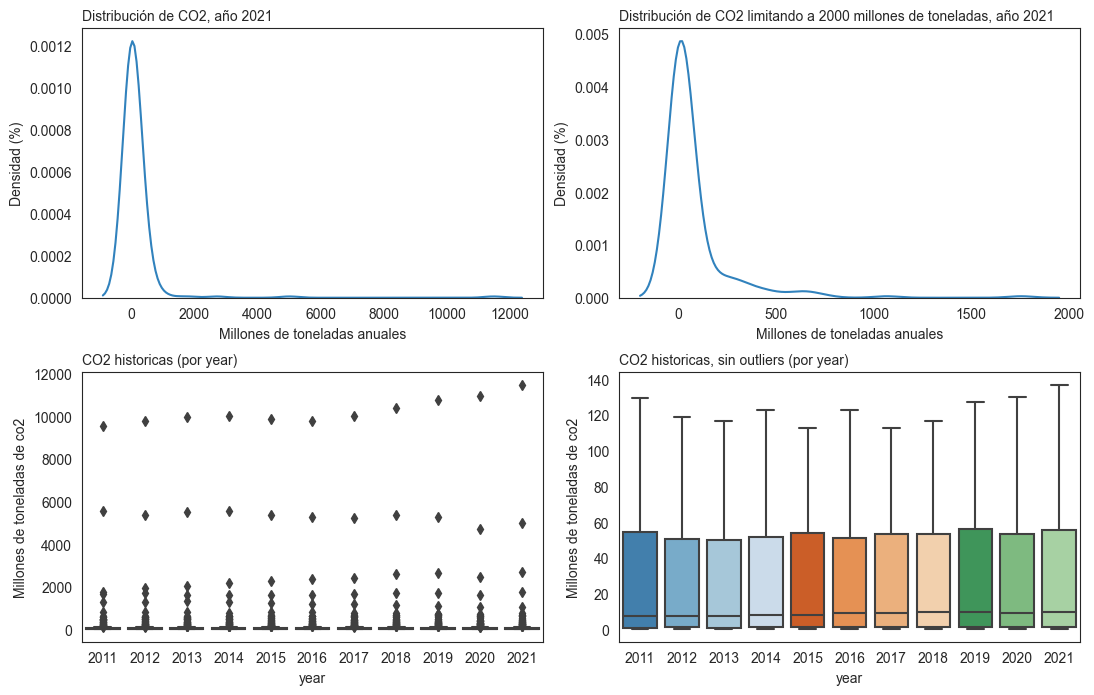

In [6]:
# Estilo global para Seaborn
sns.set_style("white") 
sns.set_palette("tab20c")  # Puedes cambiar la paleta de colores

subset2021 = df_procesado[df_procesado["year"] == 2021]

fig = plt.figure(figsize=(11, 7))
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1])

# Gráfico de densidad (KDE) con eje y normalizado a 100%
ax1 = fig.add_subplot(gs[0, 0])
sns.kdeplot(data=subset2021['co2'], ax=ax1, common_norm=True)
ax1.set_title('Distribución de CO2, año 2021', loc='left', fontsize=10)
ax1.set_xlabel('Millones de toneladas anuales')
ax1.set_ylabel('Densidad (%)')

# Gráfico de densidad (KDE) hasta el percentil 90
ax2 = fig.add_subplot(gs[0, 1])
sns.kdeplot(data=subset2021['co2'][subset2021["co2"]<2000], ax=ax2, common_norm=True)
ax2.set_title('Distribución de CO2 limitando a 2000 millones de toneladas, año 2021', loc='left', fontsize=10)
ax2.set_xlabel('Millones de toneladas anuales')
ax2.set_ylabel('Densidad (%)')

# Gráfico de caja con outliers agrupado por la variable country_2
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df_procesado[df_procesado["year"] > 2010], x='year', y='co2', ax=ax3)
ax3.set_title('CO2 historicas (por year)', loc='left', fontsize=10)
ax3.set_ylabel('Millones de toneladas de co2')

# Gráfico de caja sin outliers agrupado por la variable country_2
ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df_procesado[df_procesado["year"] > 2010], x='year', y='co2', ax=ax4, showfliers=False)
ax4.set_title('CO2 historicas, sin outliers (por year)', loc='left', fontsize=10)
ax4.set_ylabel('Millones de toneladas de co2')

# Ajustar el tamaño de fuente global (opcional)
plt.rc('font', size=8)  # Puedes cambiar el tamaño de la fuente aquí

plt.tight_layout()
plt.show()


A su vez, hay otras variables que nos sirven para desagregar CO2 por tipo de combustibles u origen de las emisiones, entre ellas cement_co2, coal_co2, flaring_co2, gas_co2, land_use_change_co2, oil_co2.

In [7]:
subset2021.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
gdp,165.0,6.901456e+11,2.187724e+12,6.678104e+08,3.121292e+10,1.004160e+11,4.313199e+11,1.815162e+13
year,230.0,2.021000e+03,0.000000e+00,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03,2.021000e+03
cumulative_coal_co2,218.0,3.688560e+03,1.877875e+04,0.000000e+00,0.000000e+00,1.226000e+01,5.610500e+02,1.870734e+05
cumulative_flaring_co2,218.0,8.465000e+01,2.810800e+02,0.000000e+00,0.000000e+00,7.000000e-02,1.775000e+01,2.421250e+03
cumulative_gas_co2,218.0,1.165400e+03,5.954330e+03,0.000000e+00,0.000000e+00,3.210000e+00,3.397300e+02,7.854255e+04
cumulative_luc_co2,212.0,4.775880e+03,1.560592e+04,-4.701390e+03,1.622000e+01,5.849400e+02,3.146090e+03,1.243909e+05
cumulative_oil_co2,218.0,2.579540e+03,1.184189e+04,2.900000e-01,3.410000e+01,2.082300e+02,1.420930e+03,1.612750e+05
cumulative_other_co2,46.0,2.105300e+02,7.414200e+02,0.000000e+00,1.598000e+01,3.619000e+01,1.150700e+02,4.899550e+03
cumulative_cement_co2,215.0,2.095700e+02,1.118250e+03,0.000000e+00,0.000000e+00,1.977000e+01,8.429000e+01,1.565781e+04
cumulative_co2,218.0,7.769290e+03,3.548540e+04,2.900000e-01,5.019000e+01,3.359000e+02,2.948590e+03,4.219068e+05


Viendolo de otra forma, y teniendo en cuenta la poblacion o el Producto Interno Bruto (PIB), el país con las emisiones más altas es China en 2021, seguido por Estados Unidos, mientras que las emisiones más bajas se encuentran en la Antártida. Por otro lado, en terminos per capita las emisiones de EE.UU casi duplican las de China.

In [8]:
tabla_df = df_procesado[df_procesado['year'] == 2018].sort_values(['co2'], ascending=False).reset_index(drop=True)
columnas_deseadas = ["country", "co2", "population", "gdp"]
tabla_df = tabla_df[columnas_deseadas]

tabla_df = tabla_df.rename(columns={"country": "Pais", "co2": "Emisiones anuales de CO2", "population": "Poblacion", "gdp": "PIB"})

tabla_df['Emisiones anuales de CO2'] = tabla_df['Emisiones anuales de CO2'].astype(str).str.replace('.0', '')
tabla_df['Poblacion'] = tabla_df['Poblacion'].apply(lambda x: '{:.0f}'.format(x / 1000000) if pd.notnull(x) and np.isfinite(x) else x)
tabla_df['PIB'] = tabla_df['PIB'].apply(lambda x: '{:.0f}'.format(x / 1000000) if pd.notnull(x) and np.isfinite(x) else x)

tabla_df.head(11).style.background_gradient(cmap='Reds', subset=['Emisiones anuales de CO2'])


,Pais,Emisiones anuales de CO2,Poblacion,PIB
0,China,10353.877,1417,18151620
1,United States,5376.657,332,18140646
2,India,2600.447,1369,8835758
3,Russia,1700.453,146,3613410
4,Japan,1143.412,126,4867011
5,Germany,754.408,83,3885961
6,Iran,700.938,86,1398996
7,South Korea,670.169,52,1958392
8,Saudi Arabia,626.191,35,1677339
9,Indonesia,603.657,267,3075456


**Que paises son los q mas aportaron a lo largo del tiempo a las emisiones acumuladas de CO2?**

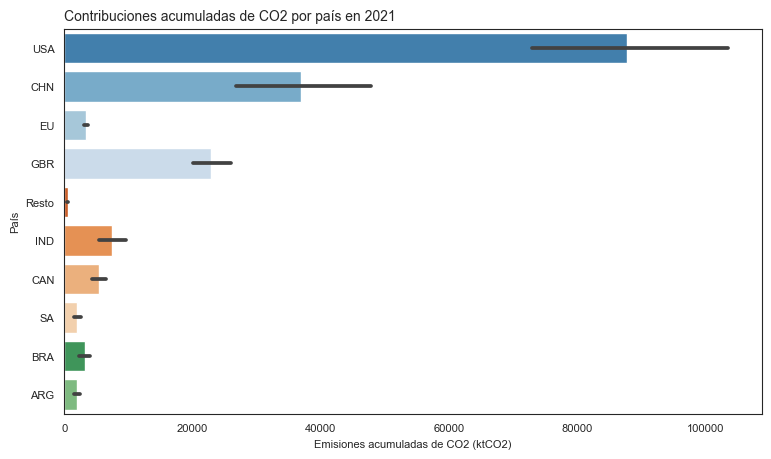

In [9]:
# Ordena el DataFrame por las contribuciones acumuladas de CO2 de manera descendente
df_sorted = df_procesado.sort_values(by='cumulative_co2', ascending=False)

# Crear un gráfico de barras horizontal
plt.figure(figsize=(9, 5))
sns.barplot(data=df_sorted, y='country_2', x='cumulative_co2')

# Establecer el título y etiquetas de los ejes
plt.title('Contribuciones acumuladas de CO2 por país en 2021', loc='left', fontsize=10)
plt.xlabel('Emisiones acumuladas de CO2 (ktCO2)')
plt.ylabel('País')

# Mostrar el gráfico
plt.show()


Entonces... 

**Que tipo de relacion (+/-) hay entre el CO2 y poblacion/ingreso?**

Para esto veo dos cosas: relacion del ingreso hoy (GDP) y la poblacion con las emisiones de co2 actuales (no acumuladas).

**Antes de tratar datos faltantes:** Como podemos ver, la relacion es positiva en ambos casos, pero pareceria q a priori hay una mayor relacion entre poblacion y co2 que entre gdp y co2. Aca puede estar sucediendo que al considerar unicamente las emisiones de co2 y no las totales de efecto invernadero nos estemos perdiendo informacion. 

**Luego de tratar datos faltantes:** la relacion entre gpd y co2 parece ser mas fuerte que con poblacion. Aca se ve algo importante, que es que si bien los paises con mayor poblacion tienen mas emisiones por la simple razon de que mas personas emiten mas, hay paises dado su nivel de gdp tienen emisiones per capita mas altas. Esto nos quiere decir que los habitantes de personas en paises de menor desarrollo relativo


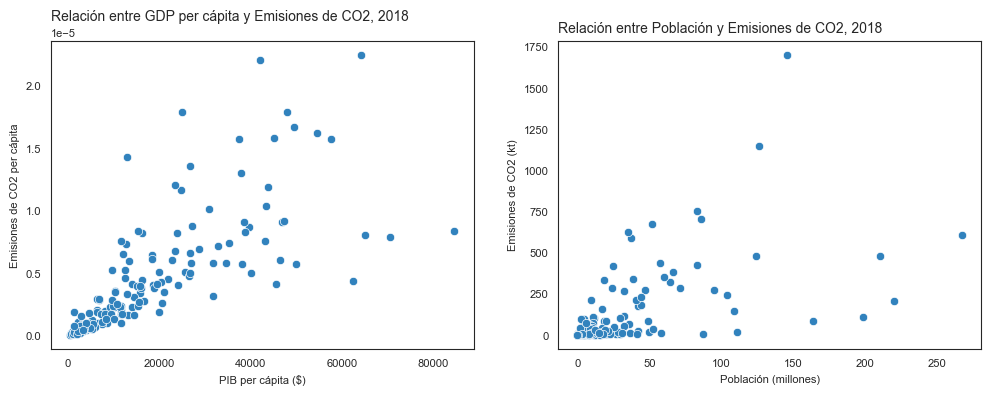

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 
sns.set_palette("tab20c")

# Crear una figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

subset_0515 = graficos_df.loc['2018-01-01'].copy()
subset_0515['population_M'] = subset_0515['population'] / 1000000
subset_0515['gdp_pc'] = subset_0515['gdp'] / subset_0515['population']
subset_0515['co2_pc'] = subset_0515['co2'] / subset_0515['population']


# Gráfico 1: GDP vs CO2
q_low = subset_0515["co2_pc"].quantile(0.01)
q_hi = subset_0515["co2_pc"].quantile(0.99)
graf1 = subset_0515[(subset_0515["co2_pc"] < q_hi) & (subset_0515["co2_pc"] > q_low)]

sns.scatterplot(data=graf1, x="gdp_pc", y="co2_pc", ax=ax1)
ax1.set_xlabel("PIB per cápita ($)")
ax1.set_ylabel("Emisiones de CO2 per cápita")
ax1.set_title("Relación entre GDP per cápita y Emisiones de CO2, 2018", loc='left', fontsize=10)

# Gráfico 2: Población y CO2
q_low = subset_0515["population_M"].quantile(0.01)
q_hi = subset_0515["population_M"].quantile(0.99)
graf2 = subset_0515[(subset_0515["population_M"] < q_hi) & (subset_0515["population_M"] > q_low)]

sns.scatterplot(data=graf2, x="population_M", y="co2", ax=ax2)
ax2.set_xlabel("Población (millones)")
ax2.set_ylabel("Emisiones de CO2 (kt)")
ax2.set_title("Relación entre Población y Emisiones de CO2, 2018", loc='left', fontsize=10)


# Mostrar los gráficos
plt.show()


**Como ingresa argentina en este contexto?**

Argentina es un pais de ingreso per capita elevado, decil 9, pero dentro de su decil se encuentra por debajo del promedio de emisiones per capita.

In [11]:
# deciles según la variable GDP
subset_0515['gdp_deciles'] = pd.qcut(subset_0515['gdp'], 10, labels=False)

# gráfico de cajas y bigotes con Plotly
fig = px.box(subset_0515, x='gdp_deciles', y='co2_pc', 
             title='CO2 per capita según deciles de GDP',
             labels={'gdp_deciles': 'Deciles de GDP', 'co2_pc': 'CO2 per capita'})

fig.update_layout(template='simple_white')

# trazo adicional para Argentina
fig.add_trace(go.Box(
    x=[9],  # Decil correspondiente a Argentina
    y=subset_0515[subset_0515['country'] == 'Argentina']['co2_pc'],  # Emisiones de CO2 per capita de Argentina
    name='Argentina',
    marker=dict(color='red'),
    boxpoints='all',
    jitter=0.3,
    pointpos=-1.8,
    showlegend=False
))

fig.show()


<img src="Graficodeciles.png">

**Principales Insigths**

A partir del analisis de los datos y del desarrollo de un modelo basico que relaciona las emisiones de CO2 de la generacion electrica con el nivel de actividad, medida a traves del Estimador Mensual de Actividad Economica (EMAE) se pueden obtener los siguientes insigths:

- Países que más han contribuido al acumulado de emisiones de CO2 a lo largo de la historia: China, Estados Unidos, países de la Unión Europea, India, Canadá, Brasil, países del sur de África y Reino Unido.

- Relación entre nivel de emisiones, Producto Interno Bruto (PIB) y población para este grupo de países: La relación entre el PIB y las emisiones de CO2 parece ser más fuerte que la relación con la población. Aunque los países con mayor población tienden a tener mayores emisiones totales debido al mayor número de personas, algunos países con un nivel de PIB más alto tienen emisiones per cápita más altas. Esto indica que los habitantes de países menos desarrollados emiten menos CO2 per cápita que aquellos en países más desarrollados.

- Distribución de las emisiones según deciles de PIB: En línea con la relación positiva entre el PIB y las emisiones per cápita, se observa que a medida que aumenta el decil de ingreso (PIB), también aumentan en promedio las emisiones. Es importante destacar que los deciles superiores de la distribución presentan una mayor dispersión de las emisiones. Hay países de altos ingresos que emiten la misma cantidad de CO2 per cápita que países en el decil 1.

- Evolución de las emisiones de Argentina Las emisiones de CO2 en Argentina han seguido aumentando desde el inicio de la serie, alcanzando un máximo antes de la pandemia. Aunque las emisiones pospandemia aún no han superado los niveles previos a la pandemia.

- Composición de las emisiones según el tipo de combustible: Hasta el año 2000, el petróleo fue la principal fuente de emisiones en Argentina. A partir de ese año, el gas comienza a superar al petróleo como el principal combustible en términos de incidencia año tras año, lo cual está directamente relacionado con su papel predominante en la matriz energética del país.

- Combustible que más ha contribuido a las emisiones acumuladas de CO2: Aunque el gas ha experimentado una dinámica importante en los últimos años, en términos acumulados aún no ha superado al stock de emisiones generadas por el petróleo en Argentina.

In [12]:
#Sub dataset para argentina
grafico3=graficos_df.copy()
grafico3=grafico3[grafico3['country_2']=="ARG"]
grafico3 = grafico3.loc['1920-01-01':]
grafico3=grafico3.reset_index()

**Como evolucionaron en el tiempo las emisiones de co2 de Argentina?**
 
 Al analizar los datos, se observa que las emisiones de CO2 han experimentado un crecimiento constante desde el comienzo de la serie. Sin embargo, se identifica un punto máximo que se alcanza antes del inicio de la pandemia. Es importante destacar que, hasta el momento, las emisiones posteriores a la pandemia no han logrado superar los niveles de emisiones previos al evento.

C:\Users\Bruno\AppData\Local\Temp\ipykernel_9656\1591143997.py:17: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.

c:\Users\Bruno\miniconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.



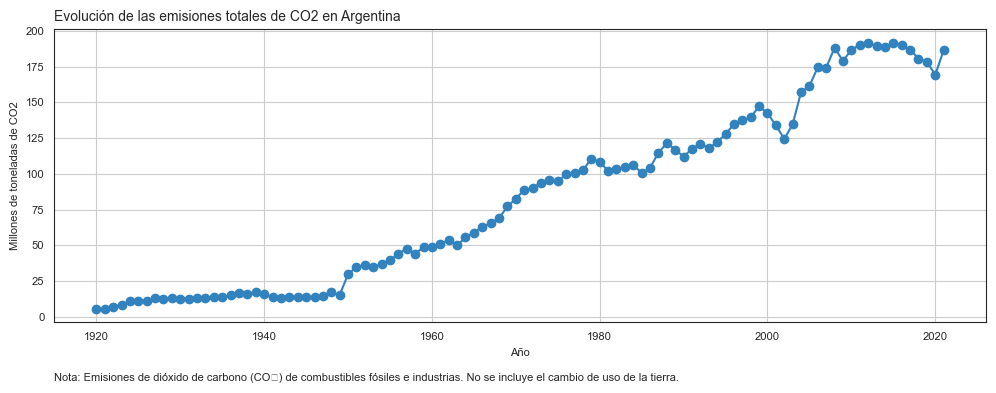

In [13]:
# Crear el gráfico de línea
plt.figure(figsize=(10, 4))
plt.plot(grafico3['year'], grafico3['co2'], marker='o', linestyle='-')

# Establecer título y etiquetas de los ejes
plt.title('Evolución de las emisiones totales de CO2 en Argentina', loc='left', fontsize=10)
plt.xlabel('Año')
plt.ylabel('Millones de toneladas de CO2')

# Añadir anotación
plt.annotate("Nota: Emisiones de dióxido de carbono (CO₂) de combustibles fósiles e industrias. No se incluye el cambio de uso de la tierra.",
             xy=(0,-0.2), xycoords='axes fraction',
             fontsize=8)

# Mostrar el gráfico
plt.grid()
plt.tight_layout()
plt.show()


**Que fuente de energia fue la de mayor dinamica?**

Hasta el año 2000, las emisiones de dióxido de carbono (CO2) estaban principalmente relacionadas con el uso del petróleo como combustible. A partir de ese año, se observa un cambio significativo en la tendencia, donde el gas comienza a superar al petróleo como el principal combustible en términos de emisiones, año tras año. Este cambio está directamente relacionado con la consolidación del gas como el componente principal de nuestra matriz energética a lo largo del tiempo. Este cambio en la composición de la matriz energética refleja una transición hacia fuentes de energía más limpias y menos intensivas en carbono.

In [14]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Coal', x=grafico3['year'], y=grafico3['coal_co2']),
    go.Bar(name='Flaring', x=grafico3['year'], y=grafico3['flaring_co2']),
    go.Bar(name='Gas', x=grafico3['year'], y=grafico3['gas_co2']),
    go.Bar(name='Oil', x=grafico3['year'], y=grafico3['oil_co2']),
    go.Bar(name='Other Industry', x=grafico3['year'], y=grafico3['other_industry_co2']),
    go.Bar(name='Cement', x=grafico3['year'], y=grafico3['cement_co2'])
])

fig.update_layout(
    barmode='stack',
    title={
        'text': 'Emisiones totales de CO2 por combustible e industria - Argentina',
        'x': 0.1,  # Alineado a la derecha
        'font': {'size': 16}  # Tamaño del título
    },
    xaxis_title='Año',
    yaxis_title='Millones de toneladas de CO2',
    template='plotly_white'  # Tema blanco
)

fig.update_traces(hovertemplate='%{y:.2f} Millones de toneladas de CO2<br>%{x}<extra></extra>')

fig.show()


<img src="combustiblearg.png">


A lo largo del período analizado, observamos un notable crecimiento en las emisiones totales de CO2. Sin embargo, a partir del año 2000, podemos apreciar que las emisiones de la mayoría de los combustibles se han mantenido estables, como se muestra en el siguiente gráfico de tasas de variación. Es importante tener en cuenta que en este gráfico, las emisiones de cada combustible se presentan de manera apilada, y en orden de incidencia predominan las emisiones de oil, gas, cemento, carbón y otros.

A partir del año 2010, la relativa estabilidad de las emisiones puede estar relacionada con un estancamiento en el crecimiento del Producto Interno Bruto (PIB). Sin embargo, en el año 2021 se observa una marcada expansión de las emisiones, lo cual podría vincularse con la recuperación económica posterior a la caída de la actividad durante el año 2020.

In [15]:
# Seleccionar las columnas necesarias
df_pct = grafico3[['year', 'coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'cement_co2']].dropna(subset=['cement_co2'])

# Calcular las tasas de variación de cada columna en relación al año anterior
df_pct = df_pct.set_index('year').pct_change().reset_index()

# Graficar las tasas de variación
fig = px.bar(df_pct, x='year', y=['coal_co2', 'flaring_co2', 'gas_co2', 'oil_co2', 'cement_co2'],
             title='Tasas de variación de emisiones de CO2 por año',
             labels={'value': 'Tasa de variación', 'variable': 'Fuente de emisiones'},
             template='simple_white')

# Mostrar el gráfico
fig.show()


<img src="variaciones.png">

**Entonces...**

Si consideramos las emisiones acumuladas de CO2 en Argentina, el petróleo ha sido el principal contribuyente en comparación con el gas. Aunque las emisiones de gas han experimentado una dinámica significativa en los últimos años, en términos acumulativos aún no han superado el volumen de emisiones generado por el petróleo en Argentina. Esto indica que a lo largo del tiempo, el petróleo ha tenido un impacto mayor en las emisiones acumuladas de CO2 en el país.

<a id="estimación-de-co2-emissions-para-argentina-sector-eléctrico"></a>
### 3. Estimacion de CO2 emissions para Argentina, sector electrico

Para calcular las emisiones de CO2 de la generación de electricidad voy a seguir la siguiente fórmula:

**Emisiones de CO2 = Cantidad de combustible consumido x Factor de emisión de CO2 del combustible**

La cantidad de combustible consumido se mide en unidades físicas, como metros cúbicos (m3), toneladas (t) o litros (L), dependiendo del tipo de combustible. El factor de emisión de CO2 del combustible se expresa en unidades de masa de CO2 por unidad de combustible consumido, como kgCO2/m3, tCO2/t o kgCO2/L. En este caso voy a utilizar los FE (factores de emision) en toneladas estimados para Argentina por las secretarias de Energia y Desarrollo Sustentable de la Nacion:

<img src="FF.png">

Por ejemplo, si se quema 1000 m3 de gas natural para generar electricidad y el factor de emisión de CO2 del gas natural es de 1,936 tCO2/dam3, entonces las emisiones de CO2 generadas serían:

- **Emisiones de CO2 = 1000 dam3 x 1,936 tCO2/dam3**
- **Emisiones de CO2 = 1830 tCO2**

Es importante destacar que al considerar solo las emisiones de CO2 se está ignorando la contribución de otros gases de efecto invernadero que pueden ser emitidos durante la producción, transporte y uso del combustible. Por lo tanto, es importante tener en cuenta que la huella de carbono total de la generación de electricidad puede ser mayor que la cantidad de emisiones de CO2 calculada solo a partir del factor de emisión de CO2 del combustible.

CAMMESA presenta una estimacion de las emisiones por tipo de gas, por lo que podemos comprar la estimacion que hice con los datos de cammesa a modo de control.

In [16]:
import statsmodels.api as sm
def backward_elimination(data, target,significance_level = 0.05):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

In [17]:
def forward_selection(data, target, significance_level=0.01):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

In [18]:
def stepwise_selection(data, target,SL_in=0.05,SL_out = 0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

<a id="mco"></a>

**3.1. Regresores simples: MCO y RandomForest**

In [19]:
df_c_mensual=pd.read_excel(r"C:\Users\Bruno\Desktop\Curso Data Science\Dataframes\Combustibles Mensual.xlsx", sheet_name="combustible")
df_c_mensual.columns = df_c_mensual.columns.str.lower()
df_c_mensual['fecha'] = pd.to_datetime(df_c_mensual['fecha'], format='%Y-%m-%d')

f_emision = {
    "c_gas natural": 1.94819592,
    "c_fuel oil": 3.17228090666667,
    "c_gas oil": 2.69717055226667,
    "c_carbón mineral": 2.33525776
}

for key in f_emision:
    df_c_mensual["ep_" + key] = (df_c_mensual[key] * f_emision[key])/1000000
    
df_c_mensual["ep_total"] = df_c_mensual.filter(like="ep_").sum(axis=1)
df_c_mensual

df_c_mensual = df_c_mensual.set_index('fecha')


**Seleccion de variables**

In [20]:
variables_independientes = df_c_mensual[["demanda_energia", "emae_original", "porc_renovable","generacion","p_monomico_transporte","importacion"]]
variables_pca = df_c_mensual[["emae_original", "porc_renovable","generacion"]]
variable_target= df_c_mensual[["ep_total"]]
backward_elimination(variables_independientes,variable_target, significance_level=0.05)

['emae_original', 'porc_renovable', 'generacion']

In [21]:
forward_selection(variables_independientes,variable_target, significance_level=0.05)

['generacion', 'porc_renovable', 'emae_original']

In [22]:
stepwise_selection(variables_independientes,variable_target)

['generacion', 'porc_renovable', 'emae_original']

In [23]:
xticks = pd.date_range(start=df_c_mensual.index.min(), end=df_c_mensual.index.max(),
                      freq='M')

In [24]:
n_train = 99

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # Dividir entre train y test
    X_train, X_test = features[:n_train], features[n_train:]
    # Dividimos el valor a predecir
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    
    if isinstance(regressor, LinearRegression):
        # Si el modelo es LinearRegression, se puede acceder directamente a los coeficientes.
        coeficiente = regressor.coef_
        print('Coeficiente del regresor (LinearRegression):', coeficiente)
    elif isinstance(regressor, RandomForestRegressor):
        # Si el modelo es RandomForestRegressor, se pueden obtener las importancias de las características (variables).
        importancias = regressor.feature_importances_
        print('Importancias de las características (RandomForestRegressor):', importancias)
    else:
        print('El modelo no es ni LinearRegression ni RandomForestRegressor. No se pueden obtener los coeficientes ni las importancias de las características.')

    print('Test-set R^2: {:.2f}'.format(regressor.score(X_test, y_test)))

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10,4))
    
    xticks_datetime = pd.to_datetime(xticks).to_period('M')

    # Usa todas las fechas en xticks
    plt.xticks(range(len(xticks_datetime)), xticks_datetime.strftime('%Y-%m'), rotation=90, ha='left')

    # Ajusta el intervalo de visualización para mostrar solo cada cuarto valor de xticks
    plt.locator_params(axis='x', nbins=round(len(xticks_datetime)/4))
    plt.plot(range(n_train), y_train, 'b-', label='train')
    plt.plot(range(n_train, len(y_test) + n_train),
            y_test, 'r-', label='test')
    plt.plot(range(n_train), y_pred_train, 'g--', label='prediction train')
    
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, 'k--',
            label='prediction test')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('Date')
    plt.ylabel('CO2 Emissions')


**Combinaciones de variables**

In [25]:
# Extraer los valores que queremos predecir

y = df_c_mensual.ep_total.values


X = df_c_mensual.emae_original.array.reshape(-1, 1)

X_emae_energia = np.hstack([df_c_mensual.demanda_energia.values.reshape(-1,1),
                                df_c_mensual.emae_original.values.reshape(-1,1),])

X_energia_t_mes = np.hstack([df_c_mensual.demanda_energia.values.reshape(-1,1),
                                df_c_mensual.porc_renovable.values.reshape(-1,1),
                                df_c_mensual.index.month.values.reshape(-1, 1)])

X_energia_t = np.hstack([df_c_mensual.demanda_energia.values.reshape(-1,1),
                                df_c_mensual.porc_renovable.values.reshape(-1,1)])                                

X_emae_energia_mes = np.hstack([df_c_mensual.emae_original.values.reshape(-1,1),
                                df_c_mensual.demanda_energia.values.reshape(-1,1),
                                df_c_mensual.index.month.values.reshape(-1, 1)])

X_emae_energia_mes_t = np.hstack([df_c_mensual.emae_original.values.reshape(-1,1),
                                df_c_mensual.demanda_energia.values.reshape(-1,1),
                                df_c_mensual.porc_renovable.values.reshape(-1,1),
                                df_c_mensual.index.month.values.reshape(-1, 1)])
                                
X_emae_energia_t = np.hstack([df_c_mensual.emae_original.values.reshape(-1,1),
                                df_c_mensual.demanda_energia.values.reshape(-1,1),
                                df_c_mensual.porc_renovable.values.reshape(-1,1)])

X_emae_t_mes = np.hstack([df_c_mensual.emae_original.values.reshape(-1,1),
                                df_c_mensual.porc_renovable.values.reshape(-1,1),
                                df_c_mensual.index.month.values.reshape(-1, 1)]) 

X_emae_gene_renov_esta = np.hstack([df_c_mensual.emae_original.values.reshape(-1,1),
                                df_c_mensual.porc_renovable.values.reshape(-1,1),
                                df_c_mensual.index.month.values.reshape(-1, 1),
                                df_c_mensual.generacion.values.reshape(-1, 1),])

X_emae_gene_renov = np.hstack([df_c_mensual.emae_original.values.reshape(-1,1),
                                df_c_mensual.porc_renovable.values.reshape(-1,1),
                                df_c_mensual.generacion.values.reshape(-1, 1)])

#probamos solo algunas de todas las combinaciones ya que fui descantando
indep=(X_energia_t_mes,X_energia_t,X_emae_energia_mes,X_emae_energia_mes_t,X_emae_energia_t,X_emae_gene_renov,X_emae_gene_renov_esta)                                                                    

**3.1.1. Con linear regression**

Coeficiente del regresor (LinearRegression): [ 4.22927469e-07 -6.90165311e+00 -2.67695659e-02]
Test-set R^2: 0.32
Coeficiente del regresor (LinearRegression): [ 4.35719028e-07 -6.98498411e+00]
Test-set R^2: 0.30
Coeficiente del regresor (LinearRegression): [ 1.49602418e-02  4.50550706e-07 -3.04377585e-02]
Test-set R^2: 0.16
Coeficiente del regresor (LinearRegression): [ 3.65965744e-03  4.25591306e-07 -6.24333551e+00 -2.73705064e-02]
Test-set R^2: 0.46
Coeficiente del regresor (LinearRegression): [ 2.93739867e-03  4.38087620e-07 -6.45809154e+00]
Test-set R^2: 0.41
Coeficiente del regresor (LinearRegression): [ 3.13685375e-03 -7.68052795e+00  4.51931154e-07]
Test-set R^2: 0.14
Coeficiente del regresor (LinearRegression): [ 3.92236131e-03 -7.41267078e+00 -2.89953547e-02  4.41812125e-07]
Test-set R^2: 0.24


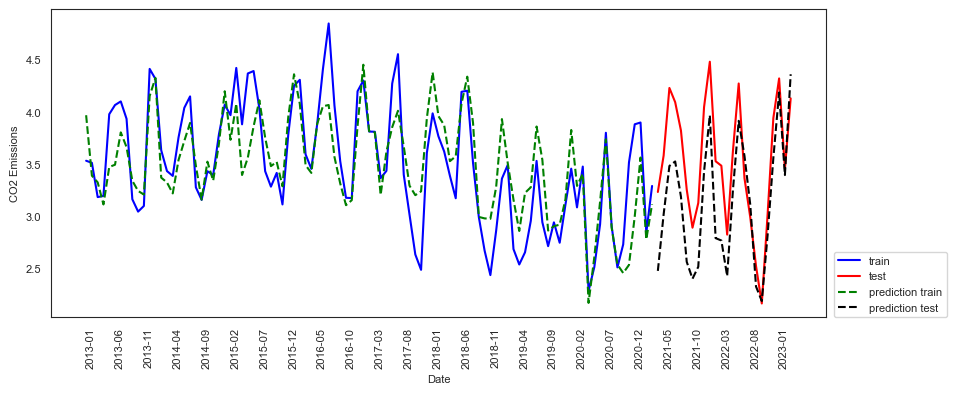

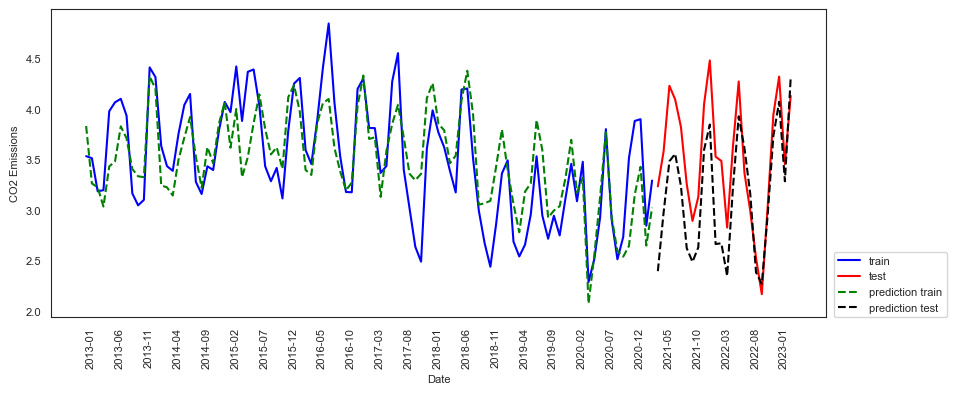

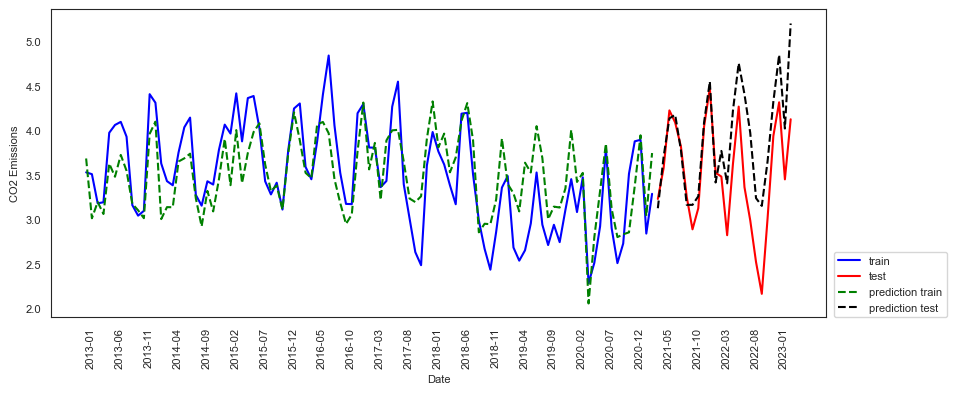

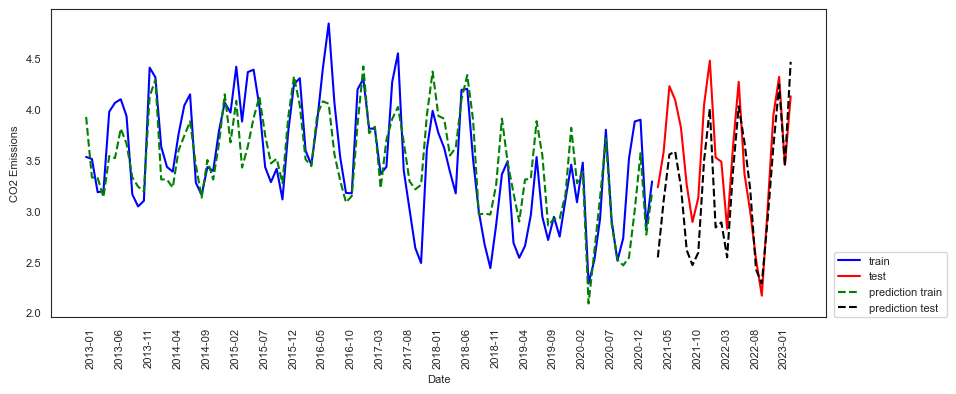

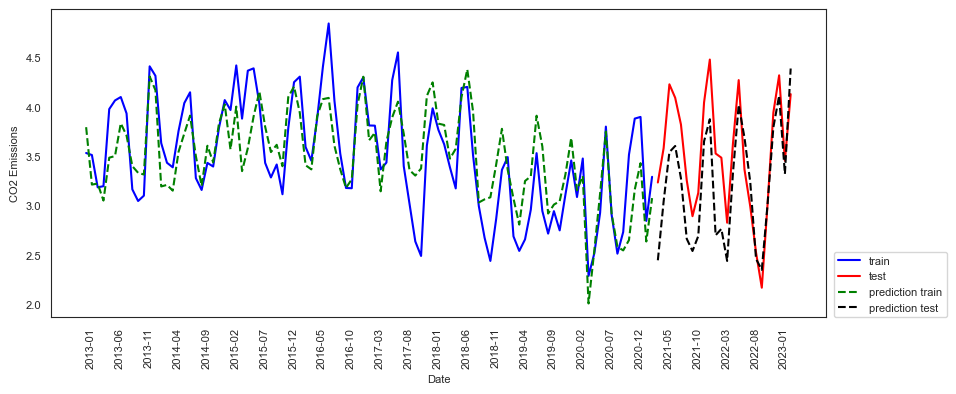

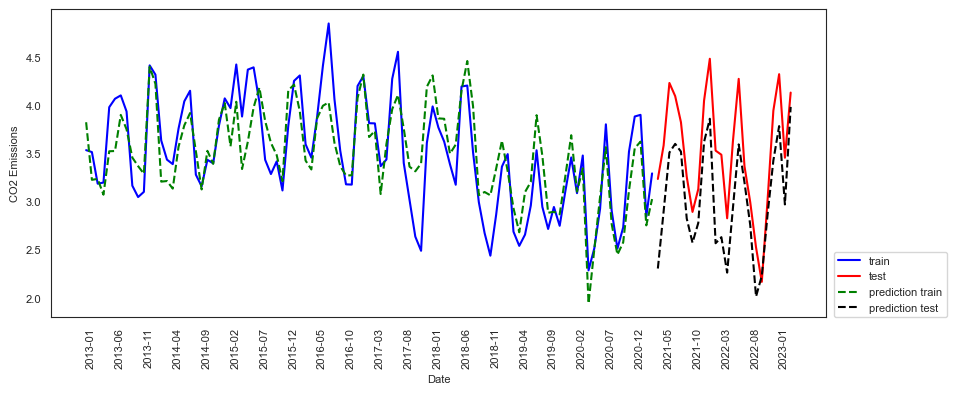

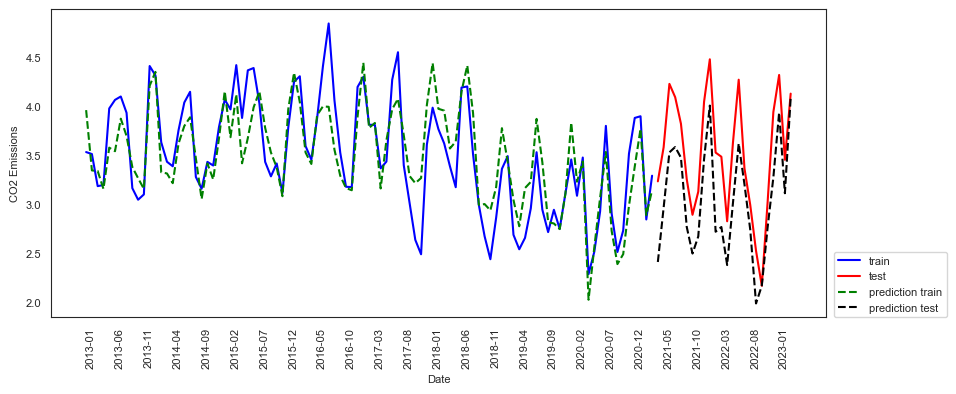

In [26]:
from sklearn.linear_model import LinearRegression

for i in indep:
    eval_on_features(i, y, LinearRegression())

**3.1.2. Con Ranom Forest**

Importancias de las características (RandomForestRegressor): [0.48056587 0.45009647 0.06933766]
Test-set R^2: 0.52
Importancias de las características (RandomForestRegressor): [0.51477401 0.48522599]
Test-set R^2: 0.50
Importancias de las características (RandomForestRegressor): [0.2729633  0.63192618 0.09511052]
Test-set R^2: 0.36
Importancias de las características (RandomForestRegressor): [0.08067661 0.45425873 0.41650663 0.04855804]
Test-set R^2: 0.40
Importancias de las características (RandomForestRegressor): [0.09672353 0.47024014 0.43303633]
Test-set R^2: 0.38
Importancias de las características (RandomForestRegressor): [0.08090367 0.42372774 0.49536859]
Test-set R^2: 0.59
Importancias de las características (RandomForestRegressor): [0.06683226 0.41422266 0.03672647 0.48221861]
Test-set R^2: 0.59


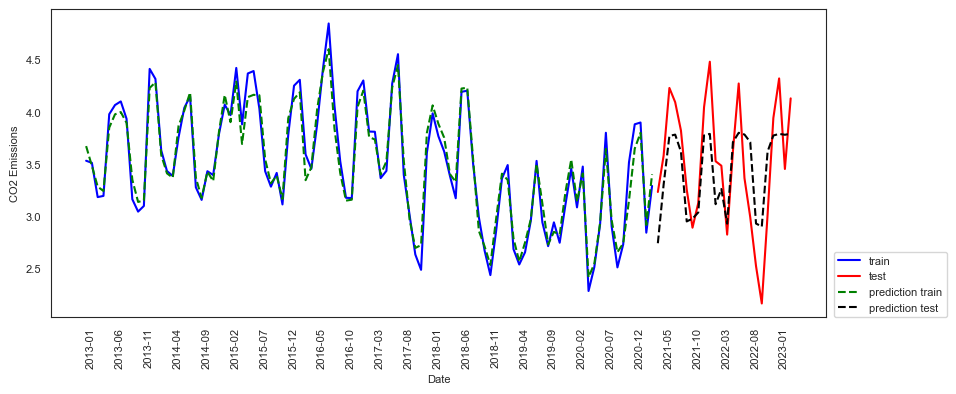

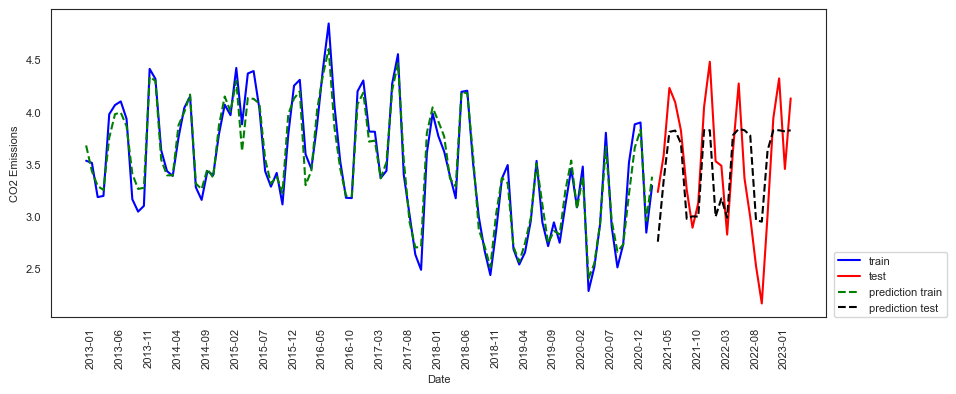

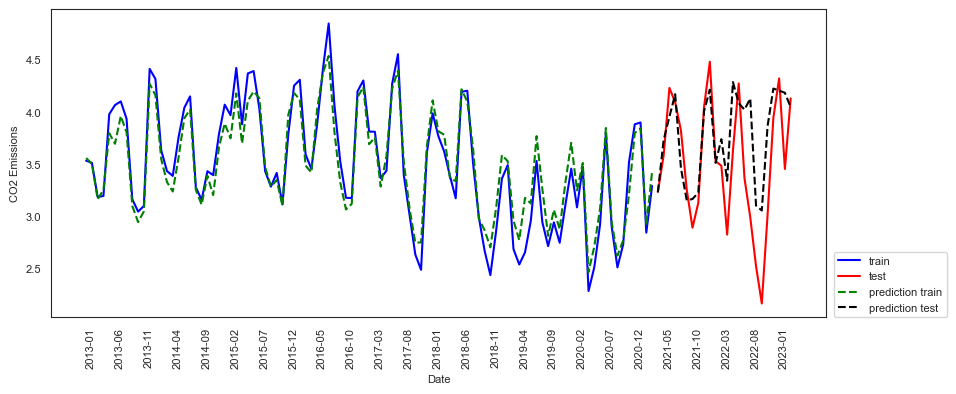

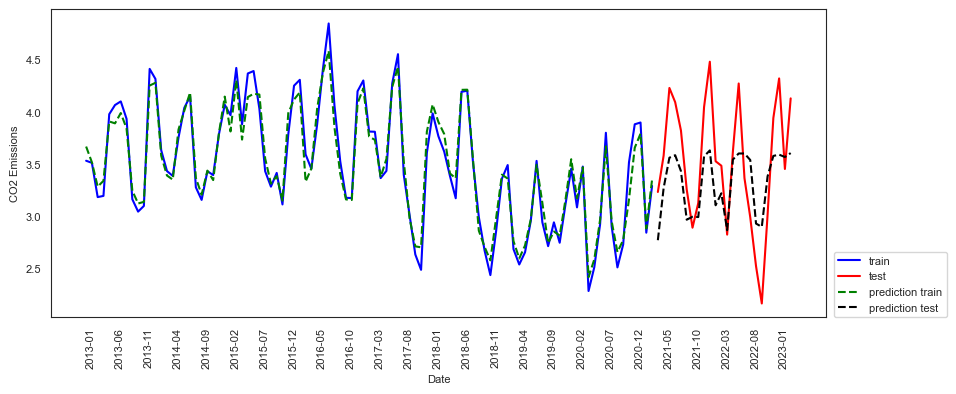

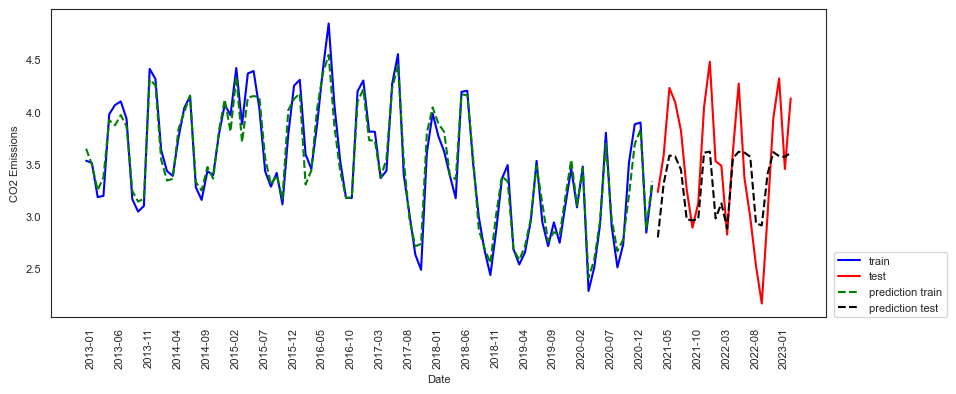

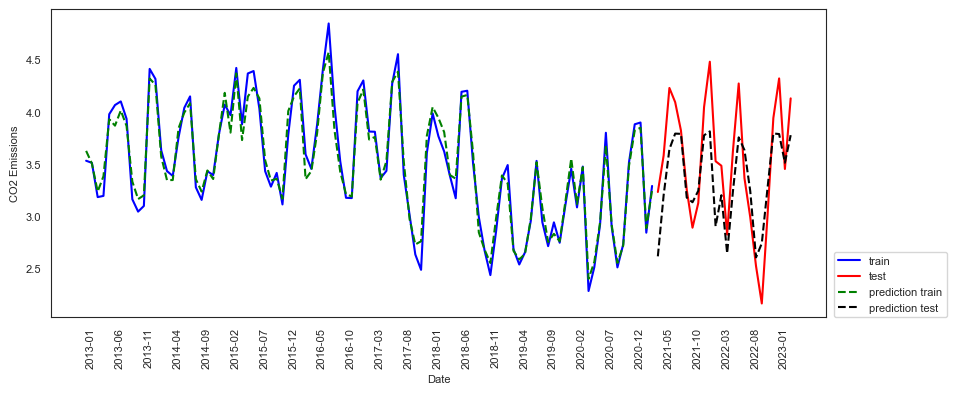

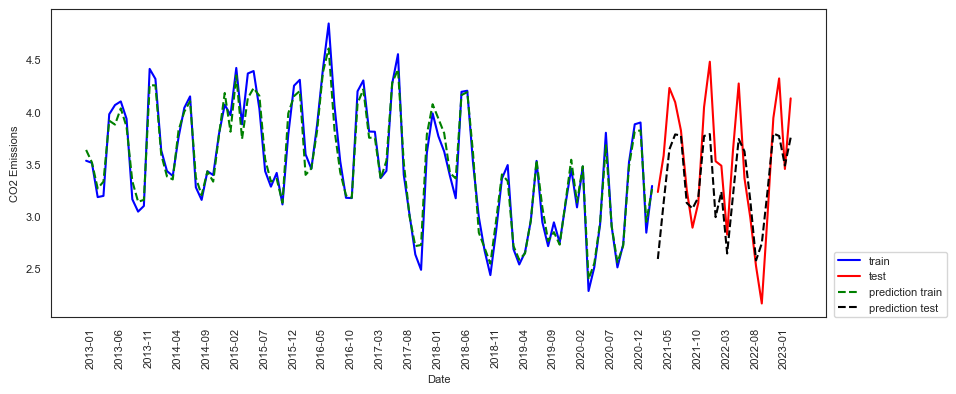

In [27]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, random_state=0)

for i in indep:
    eval_on_features(i, y, regressor)

A partir de la incorporacion de nuevas variables logramos un mejor R2:0.6

El mejor modelo resulto ser unsando un regresor RandomForest con tres variables salientes a partir de seleccion de features:
- EMAE
- Estacionalidad
- Porcentaje de energia renovable
- Generacion total de energia

**Seleccion de Hiperparametros** 

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_emae_gene_renov, y, test_size=0.3)

random_forest = RandomForestRegressor()

params = {
    'n_estimators' : [50,100,200],
    'max_features': [2,3],
    'criterion': ['squared_error', 'mse', 'absolute_error', 'poisson'],
}

grid_random_forest = GridSearchCV(estimator = random_forest,
                                  param_grid = params,
                                  scoring = 'neg_mean_absolute_error',  #
                                  cv = 6, 
                                  verbose = 1, #Muestra el resultado en pantalla
                                  n_jobs = -1) # corrida en paralelo

In [29]:
%%time
#Entrenamos el modelo 
rf_model=grid_random_forest.fit(X_train, y_train)

Fitting 6 folds for each of 24 candidates, totalling 144 fits


CPU times: total: 562 ms
Wall time: 13.2 s


c:\Users\Bruno\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning:


36 fits failed out of a total of 144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Bruno\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Bruno\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "c:\Users\Bruno\miniconda3\lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\Bruno\miniconda3\lib\site-

In [30]:
#Obtenemos el mejor modelo!
grid_random_forest.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_features=2,
                      n_estimators=50)

In [31]:
grid_random_forest.best_params_

{'criterion': 'absolute_error', 'max_features': 2, 'n_estimators': 50}

In [32]:
random_forest_nuevo = RandomForestRegressor(criterion='poisson', max_features= 3,n_estimators=50) #Instanciamos el modelo

Importancias de las características (RandomForestRegressor): [0.07768256 0.41820743 0.50411001]
Test-set R^2: 0.55


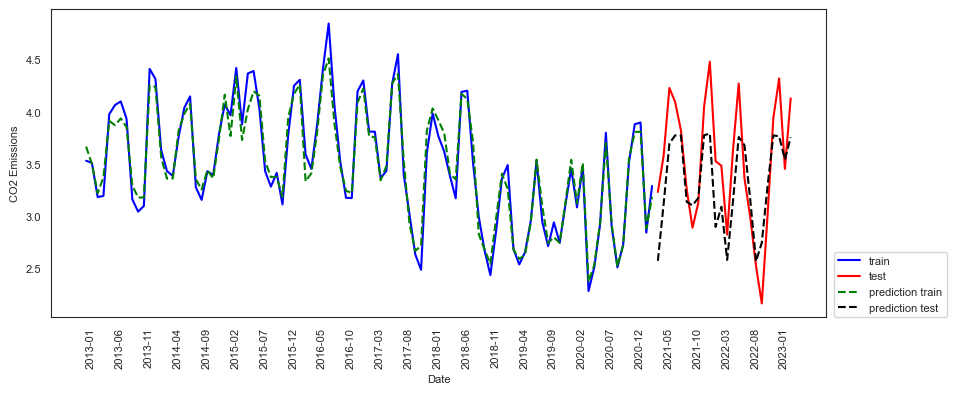

In [33]:
eval_on_features(X_emae_gene_renov, y, random_forest_nuevo)

In [34]:
y_pred = rf_model.predict(X_test)
#Evaluación de Modelos
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.2511562108589695
Mean Squared Error: 0.0980309428793316
Root Mean Squared Error: 0.31309893465058547


**3.2. Construyendo un SARIMAX (seasonal ARIMA con var exogenas)**

Uno de los métodos comunes para predecir series temporales es el modelo ARIMA, que se utiliza para entender y prever puntos futuros en la serie. 

Este modelo se basa en tres números (p, d, q) que describen la tendencia, la estacionalidad y el ruido en los datos.

- p: Toma en cuenta valores pasados para predecir el futuro.
- d: Mide cuántos pasos atrás restamos para obtener datos comparables.
- q: Usa errores pasados para ajustar el modelo.

Cuando hay efectos estacionales, usamos ARIMA estacional (ARIMA(p,d,q)(P,D,Q)s), con parámetros similares pero aplicados a la estacionalidad. 

Ahora, si quiero mejorar las predicciones y considerar factores externos, puedo usar el modelo SARIMAX, que permite incluir otras variables que podrían influir en tus predicciones.
<a id="sarimax"></a>


In [35]:
SARIMA_data=df_c_mensual.copy()

In [36]:
columnas_a_eliminar = ['c_gas natural', 'c_fuel oil', 'c_gas oil', 'c_carbón mineral']
SARIMA_data = SARIMA_data.drop(columnas_a_eliminar, axis=1)

In [37]:
# Resetear el índice para que 'fecha' sea una columna
SARIMA_data.reset_index(inplace=True)

# Utiliza la función melt para transformar las columnas en key-value
SARIMA_data = SARIMA_data.melt(id_vars=['fecha'], var_name='variable', value_name='valor')

SARIMA_data.set_index('fecha', inplace=True)

In [38]:
SARIMA_data = SARIMA_data[pd.Series(pd.to_datetime(SARIMA_data.index, errors='coerce')).notnull().values]

In [39]:
grafica_series = SARIMA_data.groupby('variable')

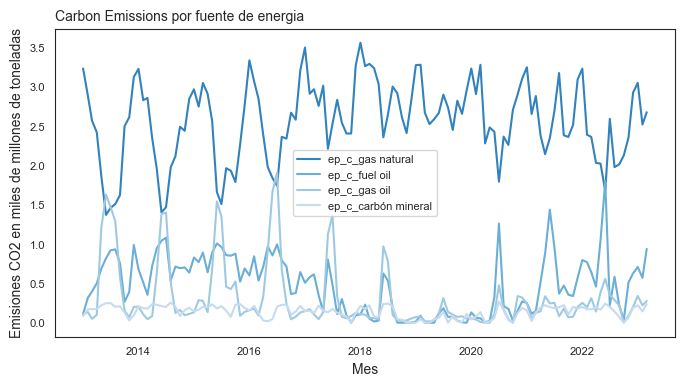

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))

# Variables deseadas
variables_deseadas = ['ep_c_gas natural', 'ep_c_fuel oil', 'ep_c_gas oil', 'ep_c_carbón mineral']

# Iterar a través de las variables deseadas
for variable in variables_deseadas:
    group = grafica_series.get_group(variable)
    fecha = group.index
    valor = group['valor']
    
    
    ax.plot(fecha, valor, label=variable)

ax.set_title('Carbon Emissions por fuente de energia', fontsize=10, loc='left')
ax.set_xlabel('Mes')
ax.set_ylabel('Emisiones CO2 en miles de millones de toneladas')
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.legend(fontsize=8)

plt.show()



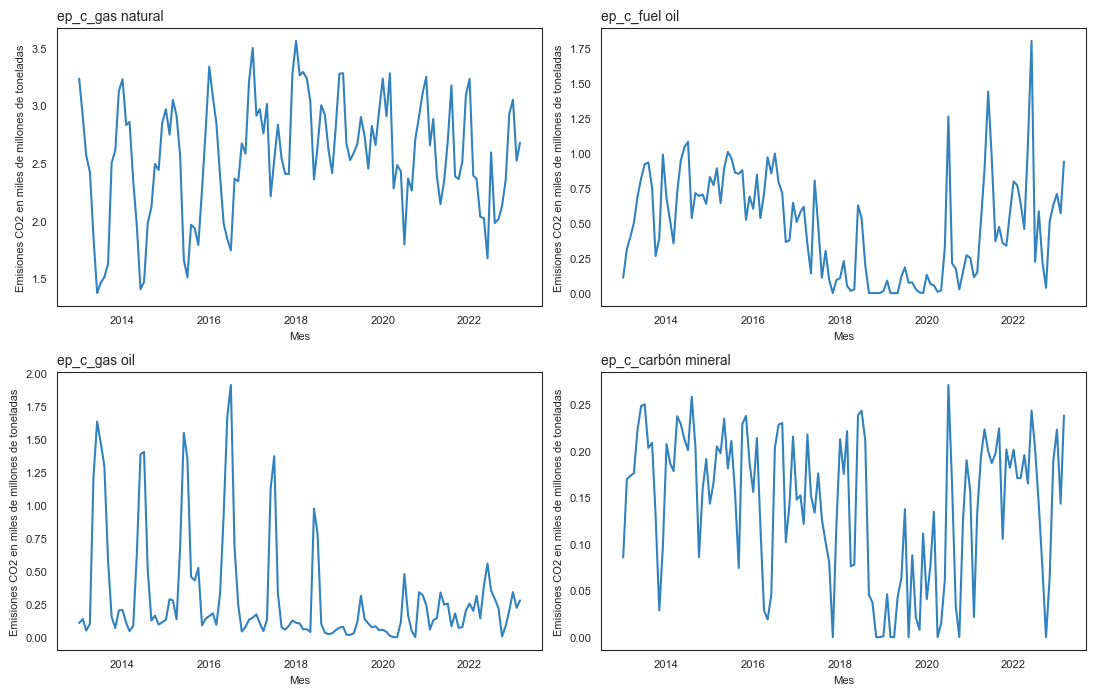

In [41]:
import matplotlib.pyplot as plt

# Variables deseadas
variables_deseadas = ['ep_c_gas natural', 'ep_c_fuel oil', 'ep_c_gas oil', 'ep_c_carbón mineral']

# Crear una matriz de subgráficos
fig, axes = plt.subplots(2, 2, figsize=(11, 7))
axes = axes.flatten()  

# Iterar a través de las variables deseadas y los subgráficos
for variable, ax in zip(variables_deseadas, axes):
    group = grafica_series.get_group(variable)
    fecha = group.index
    valor = group['valor']

    ax.plot(fecha, valor)
    ax.set_title(variable, fontsize=10, loc='left')
    ax.set_xlabel('Mes')
    ax.set_ylabel('Emisiones CO2 en miles de millones de toneladas')
    ax.xaxis.label.set_size(8)
    ax.yaxis.label.set_size(8)

plt.tight_layout()
plt.show()


Elimino datos de mte posteriores a 2022-01-01 para contar con un periodo en el que proyetar contando con variables exogenas

In [42]:
df_c_mensual.columns

Index(['c_gas natural', 'c_fuel oil', 'c_gas oil', 'c_carbón mineral',
       'demanda_energia', 'emae_original', 'porc_renovable', 'generacion',
       'p_monomico_transporte', 'importacion', 'ep_c_gas natural',
       'ep_c_fuel oil', 'ep_c_gas oil', 'ep_c_carbón mineral', 'ep_total'],
      dtype='object')

In [43]:

variable_endogena = 'ep_total'
fecha_limite = '2022-01-01'
Emissions = SARIMA_data[(SARIMA_data['variable'] == variable_endogena) & (SARIMA_data.index < fecha_limite)]
Emissions = Emissions.sort_values(by='fecha')
mte = Emissions['valor']

mte.head()

var_eliminar = ['demanda_energia', 'emae_original','p_monomico_transporte', 'importacion','c_gas natural', 'c_fuel oil', 'c_gas oil', 'c_carbón mineral', 'ep_c_gas natural',
       'ep_c_fuel oil', 'ep_c_gas oil', 'ep_c_carbón mineral', 'ep_total']
exog = df_c_mensual.drop(var_eliminar, axis=1)
exog.head()


,porc_renovable,generacion
fecha,,
2013-01-01,0.003904,1.145714e+07
2013-02-01,0.004094,1.016588e+07
2013-03-01,0.004740,1.008226e+07
2013-04-01,0.003954,9.661982e+06
2013-05-01,0.004930,1.059088e+07


In [44]:
mte = Emissions['valor']
mte.head()

fecha
2013-01-01    3.534629
2013-02-01    3.514232
2013-03-01    3.186879
2013-04-01    3.198342
2013-05-01    3.979514
Name: valor, dtype: float64

**3.2.1Testeamos estacionaridad de MTE**


In [45]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

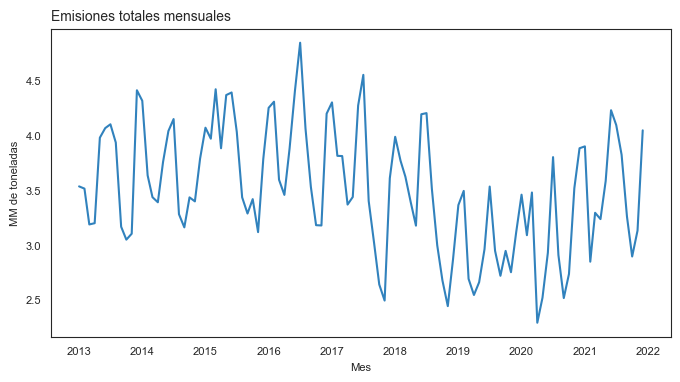

In [46]:
# Convierte el índice de tipo 'Period' a 'datetime'
#mte.index = mte.index.to_timestamp()
plt.figure(figsize=(8, 4))

plt.plot(mte)
plt.title('Emisiones totales mensuales', loc='left',fontsize=10)
plt.xlabel('Mes')
plt.ylabel('MM de toneladas')
plt.show()

In [47]:
def TestStationaryPlot(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    plt.figure(figsize=(8, 4))
    plt.plot(ts, color = 'royalblue',label = 'Original Data')
    plt.plot(rol_mean, color = 'firebrick', label = 'Rolling Mean')
    plt.plot(rol_std, color ='yellowgreen', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Meses', fontsize = 10)
    plt.ylabel('Emisiones totales', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [48]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)
    
    if ts_test[1] <= cutoff:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

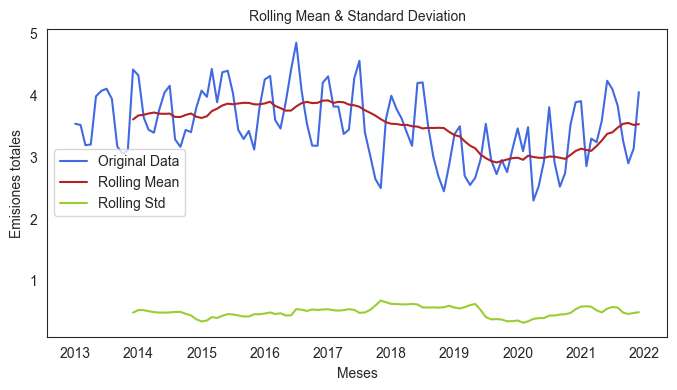

In [49]:
TestStationaryPlot(mte)

In [50]:
TestStationaryAdfuller(mte)

Test Statistic                 -0.959703
p-value                         0.767677
#Lags Used                     11.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**3.2.2 Transformamos mte (emisiones totales) a estacionaria**

Usamos primeras diferencias y media movil, primero pruebo con:

- Media movil

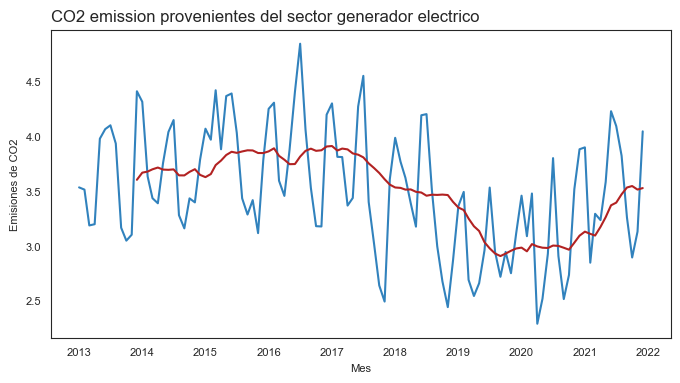

In [51]:
moving_avg = mte.rolling(12).mean()
plt.figure(figsize=(8, 4))

plt.plot(mte)
plt.plot(moving_avg, color='firebrick')
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.xlabel('Mes', fontsize = 8)
plt.ylabel('Emisiones de CO2', fontsize = 8)
plt.title('CO2 emission provenientes del sector generador electrico', fontsize = 12, loc='left')
plt.show()

In [52]:
mte_moving_avg_diff = mte - moving_avg

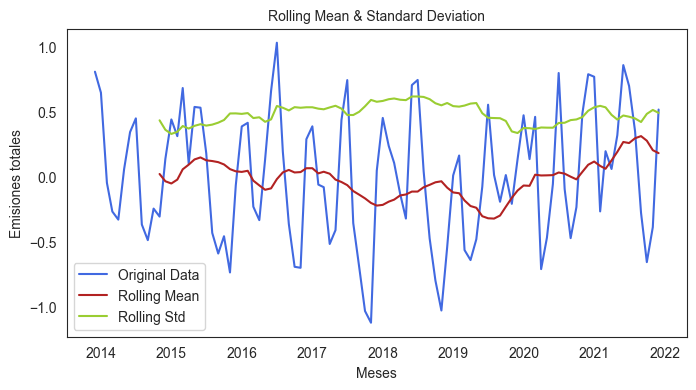

In [53]:
mte_moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(mte_moving_avg_diff)

In [54]:
TestStationaryAdfuller(mte_moving_avg_diff)

Test Statistic                 -1.466210
p-value                         0.550156
#Lags Used                     11.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Parece que aun tenemos tendencia, por lo que pruebo con 

- Eliminar tendencia y estacionaridad: primera diff

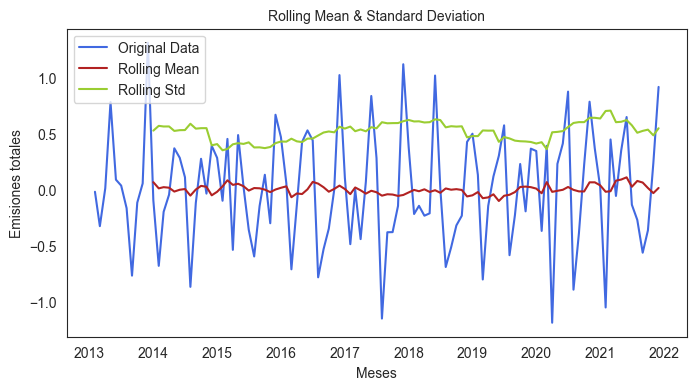

In [55]:
mte_first_difference = mte - mte.shift(1)  
TestStationaryPlot(mte_first_difference.dropna(inplace=False))

In [56]:
TestStationaryAdfuller(mte_first_difference.dropna(inplace=False))

Test Statistic                -6.856364e+00
p-value                        1.644554e-09
#Lags Used                     1.000000e+01
Number of Observations Used    9.600000e+01
Critical Value (1%)           -3.500379e+00
Critical Value (5%)           -2.892152e+00
Critical Value (10%)          -2.583100e+00
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


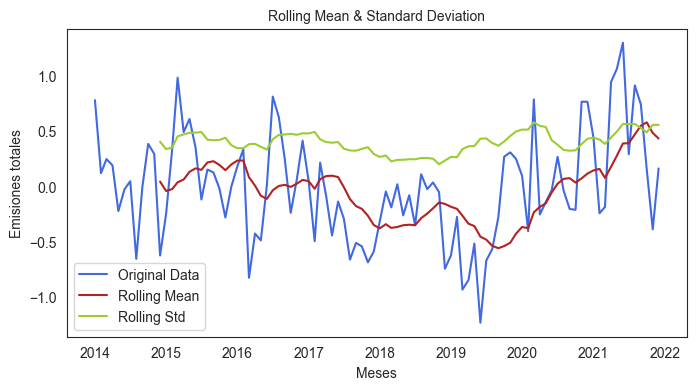

Test Statistic                 -5.375028
p-value                         0.000004
#Lags Used                      0.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


In [57]:
mte_seasonal_difference = mte - mte.shift(12)  
TestStationaryPlot(mte_seasonal_difference.dropna(inplace=False))
TestStationaryAdfuller(mte_seasonal_difference.dropna(inplace=False))

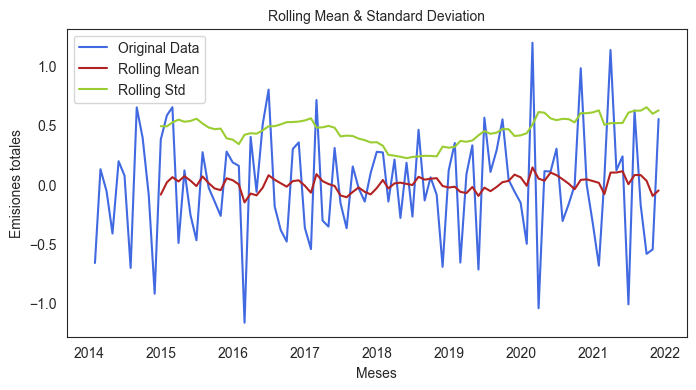

In [58]:
mte_seasonal_first_difference = mte_first_difference - mte_first_difference.shift(12)  
TestStationaryPlot(mte_seasonal_first_difference.dropna(inplace=False))

In [59]:
TestStationaryAdfuller(mte_seasonal_first_difference.dropna(inplace=False))

Test Statistic                 -4.649936
p-value                         0.000104
#Lags Used                     11.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root, hence it is stationary


Usando unicamente primeda diff y luego primera diff + seasonal ya tenemos serie estacionaria.

**3.2.3 Buscamos parametros optimos para el modelo** 


Voy a seleccionar los mejores valores de los parámetros de manera sistemática utilizando el método de grid search (optimización de hiperparámetros). El grid search explora de manera iterativa diferentes combinaciones de los parámetros. Para cada combinación de parámetros, ajustaremos un nuevo modelo estacional ARIMA con la función SARIMAX() del módulo statsmodels y evaluaremos su calidad en general. 

Una vez que se hayan explorado todas las combinaciones posibles de parámetros, nuestro conjunto óptimo de parámetros será aquel que proporcione el mejor rendimiento según nuestros criterios de interés.

In [60]:
import itertools

p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2
pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets
pdq_x_QDQs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] # Generate all different combinations of seasonal p, q and q triplets
print('Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], pdq_x_QDQs[1]))
print('SARIMAX: {} x {}'.format(pdq[2], pdq_x_QDQs[2]))

Examples of Seasonal ARIMA parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 1, 0) x (0, 1, 0, 12)


Selecciono el mejor modelo siguiendo el criterio de AKAIKE (AIC), elegimos el modelo con el AIC mas bajo

In [61]:
exog_m = exog[exog.index<fecha_limite]
import warnings

warnings.filterwarnings("ignore")

for param in pdq:
    for seasonal_param in pdq_x_QDQs:
            mod = sm.tsa.statespace.SARIMAX(endog=mte, exog=exog_m,
                                            order=param,
                                            seasonal_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, seasonal_param, results.aic))
            
warnings.resetwarnings()


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:482.0521269229642


ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:68.76479742925008
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:409.96393995253476
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:65.74514045615494
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:62.6447571818842
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:67.15797937813036
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:65.86823738283724
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:69.86222285109899
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:41.20565094024225
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:30.163638450363404
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:38.308339714784275
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:22.947843370695715
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:38.22691169338798
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:39.63096682599718
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:24.54629889537955
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:28.850045839401997
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:412.74292706033225
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:12.207873715098692
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:386.63132963305736
ARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC:30.5

Selecciono ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:7.337568384692398

In [62]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
import warnings

# Define el número de pliegues
num_folds = 5

# Divide tus datos en conjuntos de entrenamiento y prueba
tscv = TimeSeriesSplit(n_splits=num_folds)

# Inicializa una lista para almacenar las métricas de rendimiento en cada pliegue
performance_metrics = []

# Itera a través de los pliegues
for train_index, test_index in tscv.split(mte):
    train_data = mte.iloc[train_index]
    test_data = mte.iloc[test_index]
    exog_train = exog_m.iloc[train_index]
    exog_test = exog_m.iloc[test_index]
    
    # Ajusta el modelo SARIMAX en el conjunto de entrenamiento
    mod = sm.tsa.statespace.SARIMAX(endog=train_data, exog=exog_train, 
                                    order=(1, 0, 1), 
                                    seasonal_order=(0, 0, 1, 12),   
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()
    
    # Realiza pronósticos en el conjunto de prueba
    forecast = results.get_forecast(steps=len(test_data), exog=exog_test)
    
    # Calcula las métricas de rendimiento (por ejemplo, error cuadrado medio, RMSE)
    mse = ((forecast.predicted_mean - test_data) ** 2).mean()
    rmse = np.sqrt(mse)
    
    # Almacena las métricas de rendimiento en la lista
    performance_metrics.append(rmse)

# Calcula la métrica de rendimiento promedio de todos los pliegues
average_rmse = np.mean(performance_metrics)

print("Average RMSE across folds:", average_rmse)

# Restablecer las advertencias al estado predeterminado
warnings.resetwarnings()



c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\Bruno\

Average RMSE across folds: 0.7205555435875083


c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [63]:
mod = sm.tsa.statespace.SARIMAX(endog=mte, exog=exog_m, 
                                order=(1,0,1), 
                                seasonal_order=(0,0,1,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                              valor   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                   2.331
Date:                            Tue, 26 Sep 2023   AIC                              7.338
Time:                                    10:29:13   BIC                             22.597
Sample:                                01-01-2013   HQIC                            13.501
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
porc_renovable    -5.7717      0.001  -3863.503      0.000      -5.775      -5.769
generacion      3.339e-

c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



El P-value de todos los parametros incluidos es 0, por lo que es razonable incluirlos en nuestro modelo

Cuando ajustamos modelos estacionales ARIMA, es fundamental realizar un diagnóstico del modelo para asegurarnos de que no se hayan violado ninguna de las suposiciones hechas por el modelo.


El objeto plot_diagnostics nos permite generar rápidamente diagnósticos del modelo y analizar cualquier comportamiento inusual.

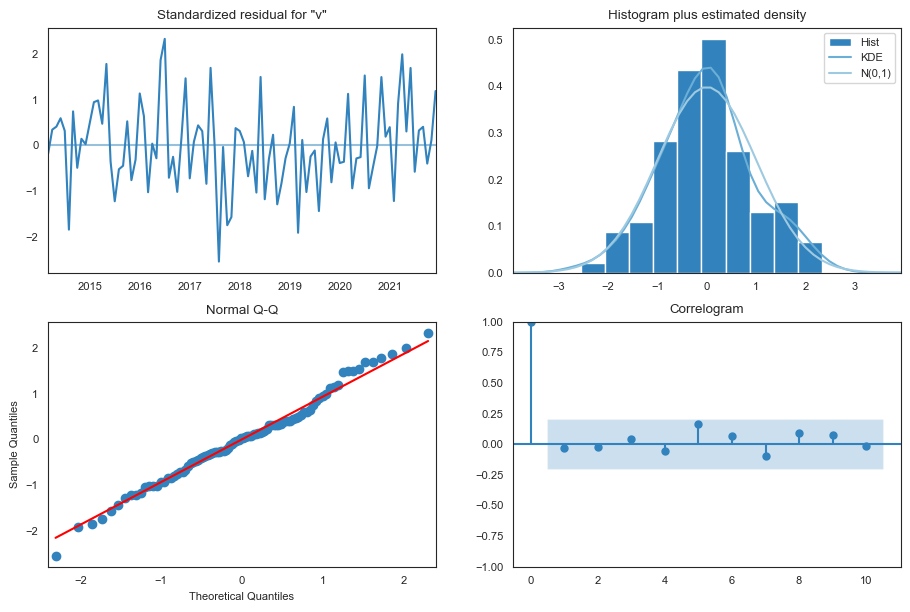

In [64]:
results.plot_diagnostics(figsize=(11, 7))
plt.show()

- En el gráfico superior derecho, la línea roja KDE sigue de cerca la línea N(0,1). Donde N(0,1) es la notación estándar para una distribución normal con media 0 y desviación estándar 1. Esto indica que los residuos siguen una distribución normal, aunque los errores de pronóstico se desvían un poco de la línea recta, lo que indica que la distribución normal no es perfecta para modelar los errores de pronóstico, pero no es irrazonable.

- El gráfico qq en la parte inferior izquierda muestra que la distribución ordenada de los residuos (puntos azules) sigue la tendencia lineal de las muestras tomadas de una distribución normal estándar. Nuevamente, esto es una fuerte indicación de que los residuos siguen una distribución normal.

- Los residuos a lo largo del tiempo (gráfico superior izquierdo) no muestran una estacionalidad evidente y parecen ser ruido blanco. Esto se confirma mediante el gráfico de autocorrelación (es decir, correlograma) en la parte inferior derecha, que muestra que los residuos de la serie temporal tienen una baja correlación con versiones rezagadas de sí mismos.

Estas observaciones nos llevan a concluir que nuestro modelo proporciona un ajuste satisfactorio

**3.2.4 Validacion de la prediccion**

Comenzamos comparando los valores pronosticados con los valores reales de la serie, lo que nos ayudará a entender la precisión de nuestra predicción. Los atributos get_prediction() y conf_int() nos permiten obtener los valores y los intervalos de confianza asociados para los pronósticos de la serie temporal.

In [65]:
exog_pos = exog[exog.index>=fecha_limite]

pred = results.get_prediction(start=85, end=122, dynamic=False, exog=exog_pos)
pred_ci = pred.conf_int()
pred_ci.tail()


,lower valor,upper valor
2022-11-01,2.364532,3.770194
2022-12-01,2.876828,4.282492
2023-01-01,3.118135,4.556194
2023-02-01,2.474121,3.935569
2023-03-01,3.156234,4.624770


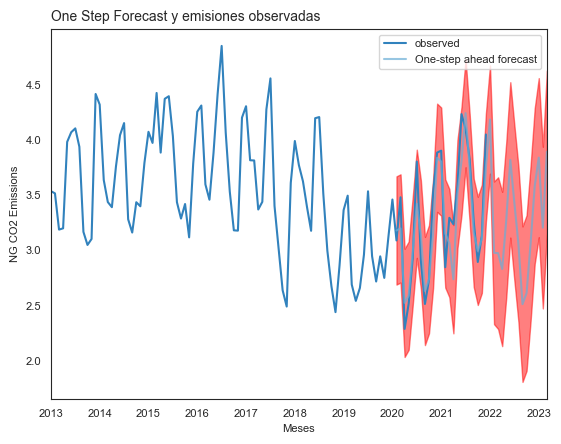

<Figure size 1400x600 with 0 Axes>

In [66]:
ax = mte['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_title('One Step Forecast y emisiones observadas', loc='left', fontsize=10)
ax.set_xlabel('Meses')
ax.set_ylabel('NG CO2 Emissions')
plt.legend()
plt.figure(figsize=(14, 6))
plt.show()

In [67]:
from sklearn.metrics import r2_score

mte_truth= SARIMA_data[(SARIMA_data['variable'] == variable_endogena) & (SARIMA_data.index > '2020-01-01')]
mte_truth = mte_truth['valor']

mte_forecast = pred.predicted_mean

# Compute the mean square error
mse = ((mte_forecast - mte_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'
      .format(np.sqrt(sum((mte_forecast-mte_truth)**2)/len(mte_forecast))))

The Mean Squared Error (MSE) of the forecast is 0.08
The Root Mean Square Error (RMSE) of the forcast: 0.2771


In [68]:
mte_pred_concat = pd.concat([mte_truth, mte_forecast])

In [69]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

c:\Users\Bruno\miniconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['full_results']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



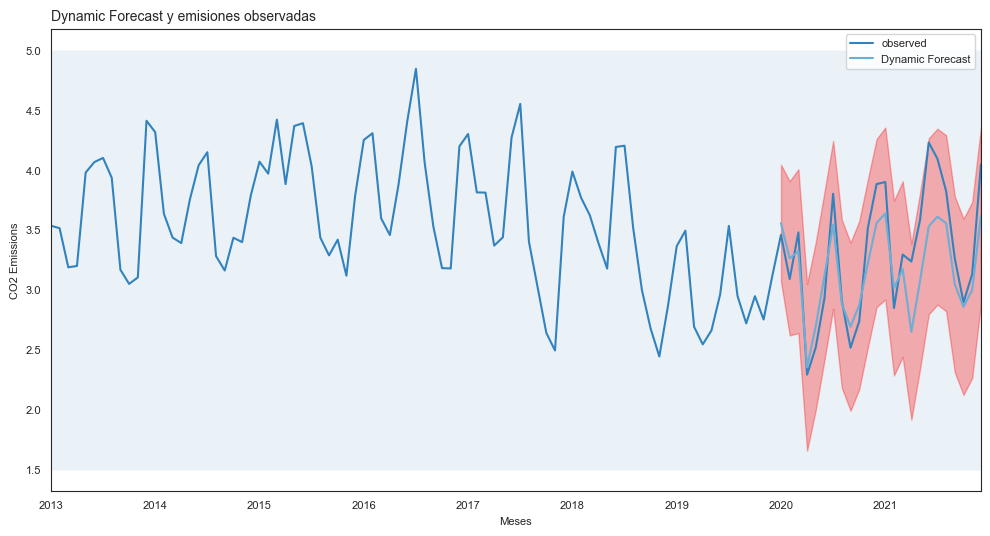

In [70]:
ax = mte['2013':].plot(label='observed', figsize=(12, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], 
                color='r', 
                alpha=.3)

ax.fill_betweenx(ax.get_ylim(), 
                 pd.to_datetime('2013-01-31'), 
                 mte.index[-1],
                 alpha=.1, zorder=-1)

ax.set_title('Dynamic Forecast y emisiones observadas', loc='left', fontsize=10)
ax.set_xlabel('Meses')
ax.set_ylabel('CO2 Emissions')

plt.legend()
plt.show()

In [71]:
from sklearn.metrics import r2_score

# Extract the predicted and true values of our time series
mte_forecast = pred_dynamic.predicted_mean
mte_original= SARIMA_data[(SARIMA_data['variable'] == variable_endogena) & (SARIMA_data.index > '2019-12-01')& (SARIMA_data.index < '2022-01-01')]
mte_original = mte_original['valor']

# Compute the mean square error
mse = ((mte_forecast - mte_original) ** 2).mean()

# Compute R-squared
r_squared = r2_score(mte_original, mte_forecast)

print('The Mean Squared Error (MSE) of the forecast is {}'.format(round(mse, 2)))
print('The Root Mean Square Error (RMSE) of the forcast: {:.4f}'.format(np.sqrt(mse)))
print('The R-squared (R^2) of the forecast is {:.4f}'.format(r_squared))


The Mean Squared Error (MSE) of the forecast is 0.09
The Root Mean Square Error (RMSE) of the forcast: 0.3034
The R-squared (R^2) of the forecast is 0.6739


**3.3 Forecasting**

In [72]:
forecast = results.get_forecast(steps= 15, exog=exog_pos)
# Get confidence intervals of forecasts
forecast_ci = forecast.conf_int()
forecast_ci.head()

,lower valor,upper valor
2022-01-01,3.692801,4.671178
2022-02-01,2.332123,3.622066
2022-03-01,2.288193,3.659459
2022-04-01,2.133289,3.528510
2022-05-01,2.571883,3.974358


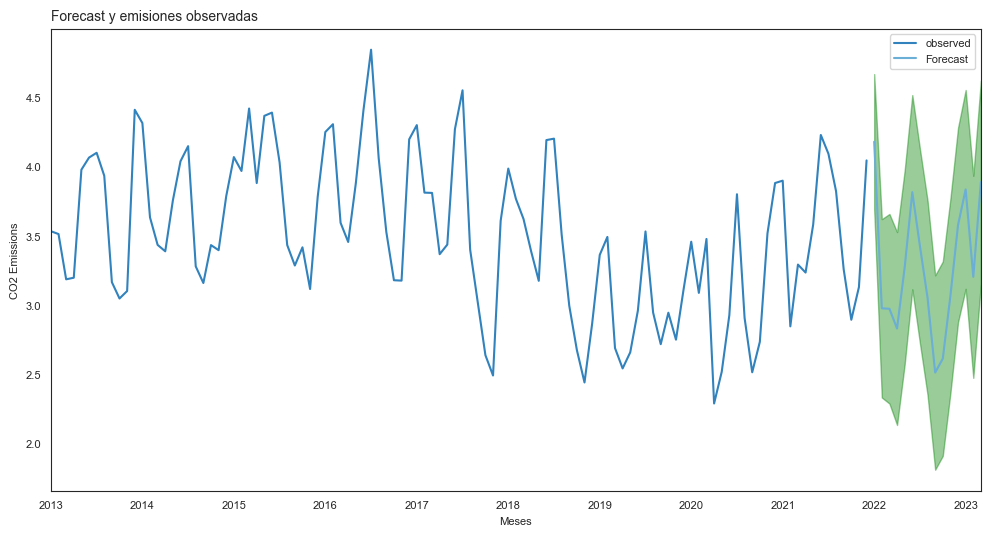

In [73]:
ax = mte.plot(label='observed', figsize=(12,6))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='g', alpha=.4)
ax.set_title('Forecast y emisiones observadas', loc='left', fontsize=10)
ax.set_xlabel('Meses')
ax.set_ylabel('CO2 Emissions')
plt.legend()
plt.show()

**4. Conclusión**

En resumen, este trabajo se centró en analisar las emisiones a nivel mundial con foco en argentina, para posteriormente desarrollar un modelo que sirva como primer paso para estimar las emisiones de dióxido de carbono provenientes del sector de generación eléctrica en Argentina. Se exploraron diversas combinaciones de variables, incluyendo la demanda de energía, el estimador mensual de actividad económica (EMAE), la temperatura media del Gran Buenos Aires y una variable dummy que captura la estacionalidad mensual. 

Se probaron tres tipos de modelo. En el caso de regresores simples, se opto por un regresor lineal (MCO) y RandomForest, siendo esto ultimo el de mejor desempeño en este grupo.
Posteriormente se continuo con la estimacion de un modelo propio de series de tiempo como es un modelo ARIMA a lo que se sumo estacionalidad, por lo que se obtuvo un SARIMA (Seasonal AutoRegressive Integrated Moving Average). Este ultimo nos permitio mejorar levemente el desempeño de los modelos previos (R2), donde se encontro una relacion negativa de las emisiones con la participacion de generacion renovable y positiva con la generacion total electrica y con componentes autorregresivos del nivel de emisiones totales del sector.

El forecasting para principios de 2023 indica un estancamiento de las emisiones, las cuales se encontrarian aun por debajo de los niveles de fines de 2021.


<a id="conclusiones"></a>